In [0]:
pip install h2o

     |████████████████████████████████| 121.8MB 1.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/d2/8a/98/1a1e50c8b6f8b6fd6e400a0d5cc268a8f68dbcc94d59420efc
Successfully built h2o


In [0]:
import h2o
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator

In [0]:
h2o.init(max_mem_size = 2) # initializing h2o server
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.3" 2019-04-16; OpenJDK Runtime Environment (build 11.0.3+7-Ubuntu-1ubuntu218.04.1); OpenJDK 64-Bit Server VM (build 11.0.3+7-Ubuntu-1ubuntu218.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpnmlbgn8n
  JVM stdout: /tmp/tmpnmlbgn8n/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpnmlbgn8n/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.4
H2O cluster version age:,9 days
H2O cluster name:,H2O_from_python_unknownUser_o3t530
H2O cluster total nodes:,1
H2O cluster free memory:,2 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


In [0]:
waterData = pd.read_csv('w.csv') 
waterData.describe()


,Tp,pH,Cond,Turb,SAC,PFM
count,132266.000000,132272.000000,132276.000000,132275.000000,132280.000000,132269.000000
mean,8.041982,8.533168,0.021095,0.128368,4.100425,68.660980
std,0.893687,0.052646,0.000347,0.005928,0.304104,11.420472
min,0.000000,0.000000,0.000000,0.000000,0.000000,42.163100
25%,7.250000,8.502780,0.020871,0.127160,3.816430,60.484900
50%,7.880000,8.539630,0.021102,0.127754,4.125515,71.440700
75%,8.710000,8.563490,0.021327,0.128686,4.395750,79.076900
max,10.300000,8.666760,0.023214,1.782850,6.102071,84.815100


In [0]:
waterData.shape

(132480, 8)

In [0]:
waterData.fillna(waterData.mean(),inplace=True)

In [0]:
waterData.fillna(waterData.mean(),inplace=True)

False

Parse progress: |█████████████████████████████████████████████████████████| 100%


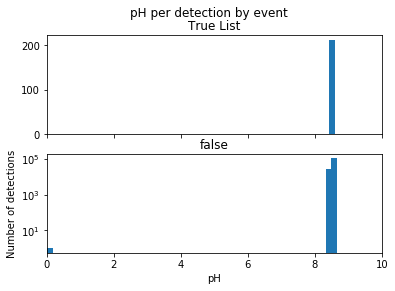

In [0]:
 #Turns python pandas frame into an H2OFrame
waterData_h2o  = h2o.H2OFrame(waterData)
TRUE= waterData[waterData.Event == 1]
FALSE = waterData[waterData.Event == 0]
# pH vs Event
f, (ax1, ax2) = plt.subplots(2,1,sharex=True)
f.suptitle('pH per detection by event')
ax1.hist(TRUE.pH, bins = 50)
ax1.set_title('True List')
ax2.hist(FALSE.pH, bins = 50)
ax2.set_title('false')
plt.xlabel('pH')
plt.ylabel('Number of detections')
plt.xlim(0, 10)
plt.yscale('log')
plt.show()

In [0]:
# time vs pH
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of detection vs pH by event')
ax1.scatter(TRUE.Time, TRUE.pH)
ax1.set_title('True List')
ax2.scatter(FALSE.Time, FALSE.pH)
ax2.set_title('False')
plt.xlabel('Time (in seconds)')
plt.ylabel('pH')
plt.show()

KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


KeyboardInterrupt: ignored

In [0]:
features= waterData_h2o.drop(['Time'], axis=1)

In [0]:
train, test = features.split_frame([0.90])
print(train.shape)
print(test.shape)

(119386, 7)
(13094, 7)


In [0]:
# converting to pandas dataframe
train_df = train.as_data_frame()
test_df = test.as_data_frame()
train_df = train_df[train_df['Event'] == 0]
# drop the Class variable
train_df = train_df.drop(['Event'], axis=1)
Y_test_df = test_df['Event'] # true labels of the testing set
test_df = test_df.drop(['Event'], axis=1)
train_df.shape

(119200, 6)

In [0]:

train_h2o = h2o.H2OFrame(train_df) # converting to h2o frame
test_h2o = h2o.H2OFrame(test_df)
x = train_h2o.columns

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
anomaly_model = H2ODeepLearningEstimator(activation = "Tanh",
                               hidden = [14,7,7,14],
                               epochs = 100,
                               standardize = True,
                                stopping_metric = 'MSE', 
                                loss = 'automatic',
                                train_samples_per_iteration = 32,
                                shuffle_training_data = True,     
                               autoencoder = True,
                               l1 = 10e-5)
anomaly_model.train(x=x, training_frame = train_h2o)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [0]:
anomaly_model._model_json['output']['variable_importances'].as_data_frame()

,variable,relative_importance,scaled_importance,percentage
0,PFM,1.000000,1.000000,0.382993
1,Tp,0.775769,0.775769,0.297115
2,SAC,0.232152,0.232152,0.088913
3,Turb,0.226545,0.226545,0.086765
4,Cond,0.217843,0.217843,0.083432
5,pH,0.158701,0.158701,0.060781


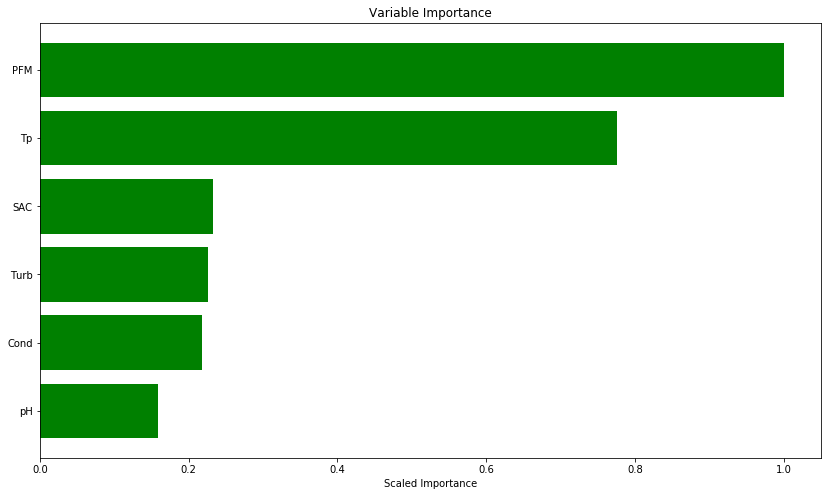

In [0]:
# plotting the variable importance
rcParams['figure.figsize'] = 14, 8
#plt.rcdefaults()
fig, ax = plt.subplots()

variables = anomaly_model._model_json['output']['variable_importances']['variable']
var = variables[0:15]
y_pos = np.arange(len(var))

scaled_importance = anomaly_model._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:15]

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()


Text(0.5, 0, 'epoch')

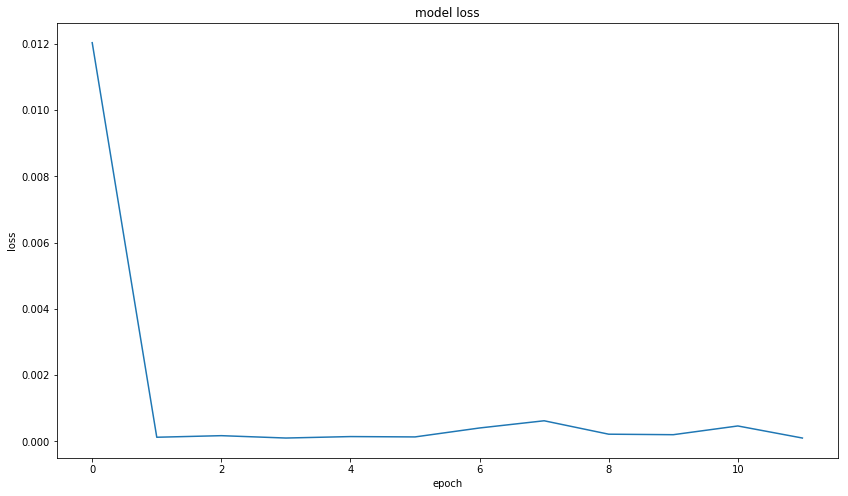

In [0]:
#plotting the loss
scoring_history = anomaly_model.score_history()
%matplotlib inline
rcParams['figure.figsize'] = 14, 8
plt.plot(scoring_history['training_mse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

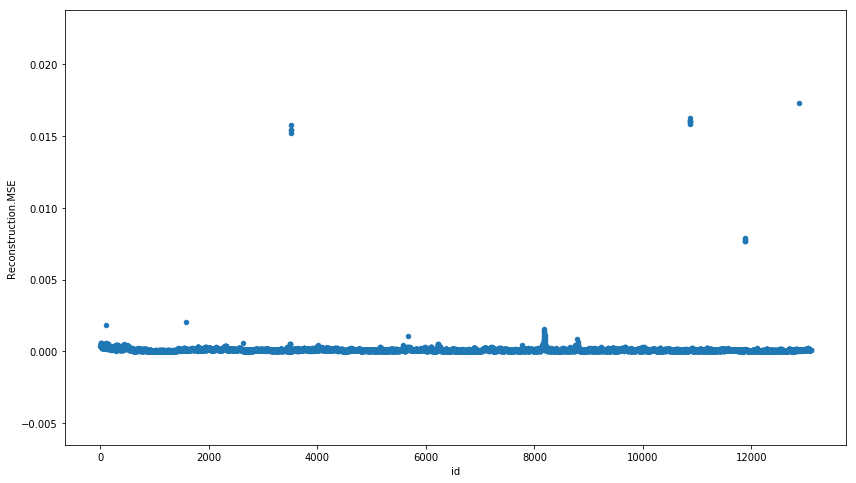

In [0]:
test_rec_error = anomaly_model.anomaly(test_h2o) 
# anomaly is a H2O function which calculates the error for the dataset
# converting to pandas dataframe
test_rec_error_df = test_rec_error.as_data_frame()
# plotting the testing dataset against the error
test_rec_error_df['id']=test_rec_error_df.index
rcParams['figure.figsize'] = 14, 8
test_rec_error_df.plot(kind="scatter", x='id', y="Reconstruction.MSE")
plt.show()

In [0]:
# predicting the class for the testing dataset
predictions = anomaly_model.predict(test_h2o)
error_df = pd.DataFrame({'reconstruction_error': test_rec_error_df['Reconstruction.MSE'],
                        'true_class': Y_test_df})
error_df.describe()

deeplearning prediction progress: |███████████████████████████████████████| 100%


,reconstruction_error
count,13094.000000
mean,0.000117
std,0.000509
min,0.000002
25%,0.000050
50%,0.000081
75%,0.000125
max,0.017264


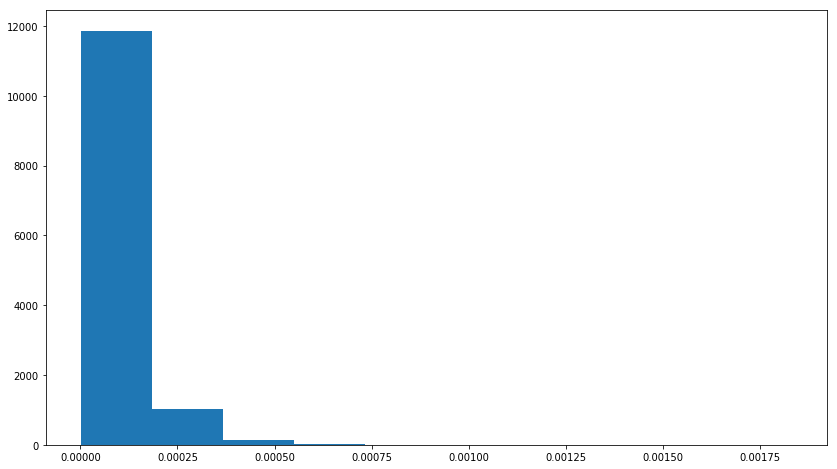

In [0]:
# reconstruction error for the normal detections in the testing dataset
fig = plt.figure()
ax = fig.add_subplot(111)
rcParams['figure.figsize'] = 14, 8
false_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(false_error_df.reconstruction_error.values, bins=10)

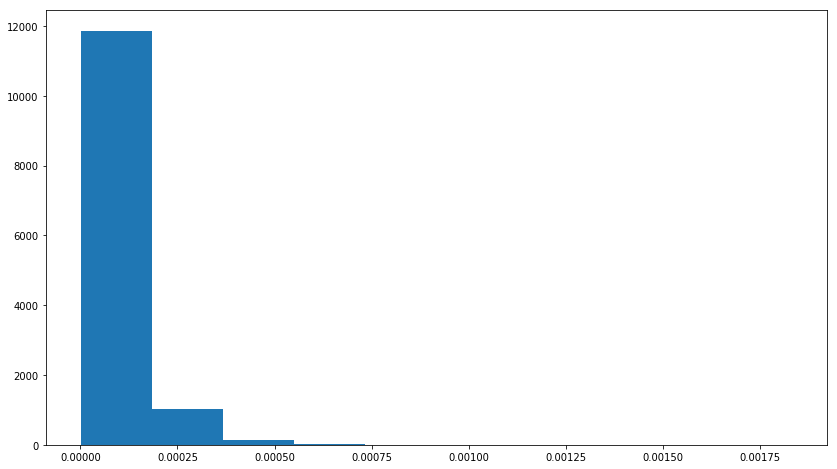

In [0]:
# reconstruction error for the fraud transactions in the testing dataset
fig = plt.figure()
ax = fig.add_subplot(111)
rcParams['figure.figsize'] = 14, 8
true_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(false_error_df.reconstruction_error.values, bins=10)

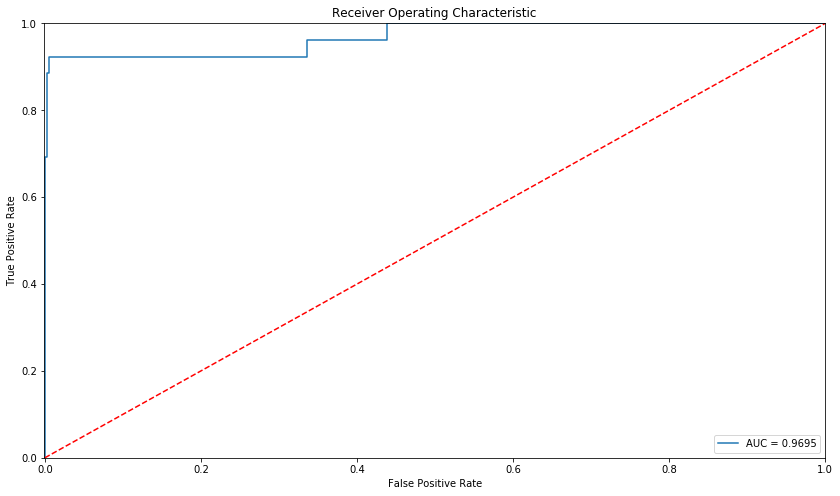

In [0]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

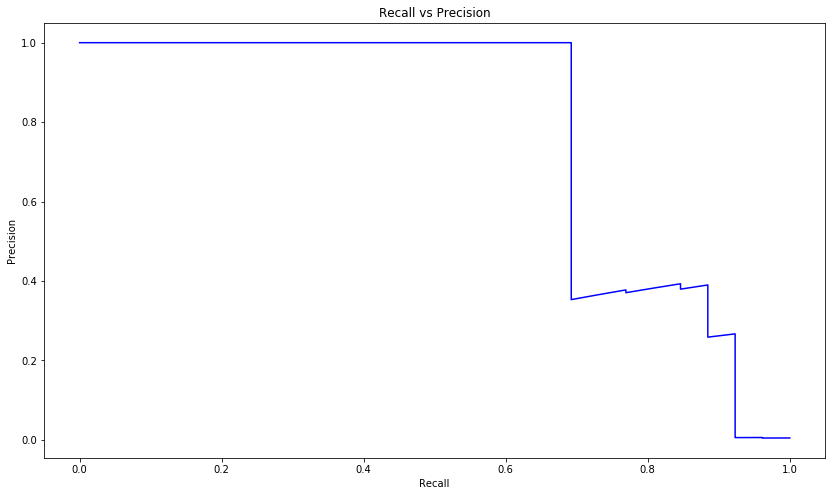

In [0]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

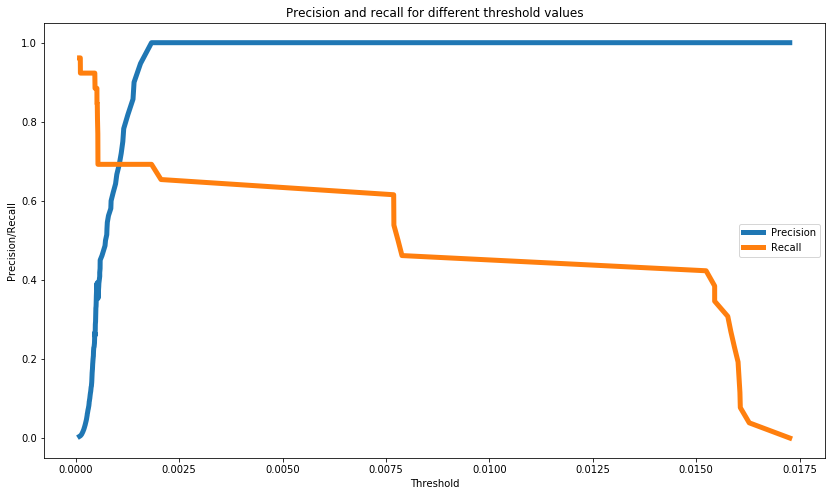

In [0]:
plt.plot(th, precision[1:], label="Precision",linewidth=5)
plt.plot(th, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

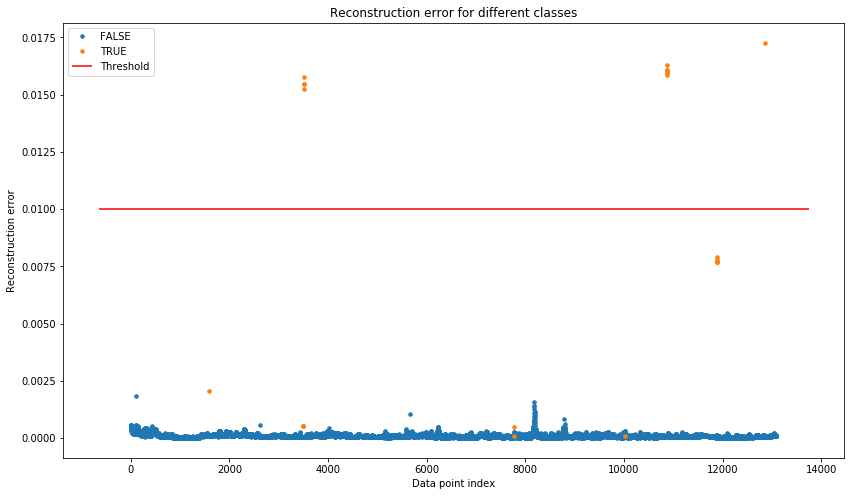

In [0]:
# plot the testing set with the threshold
threshold = 0.01
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "TRUE" if name == 1 else "FALSE")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

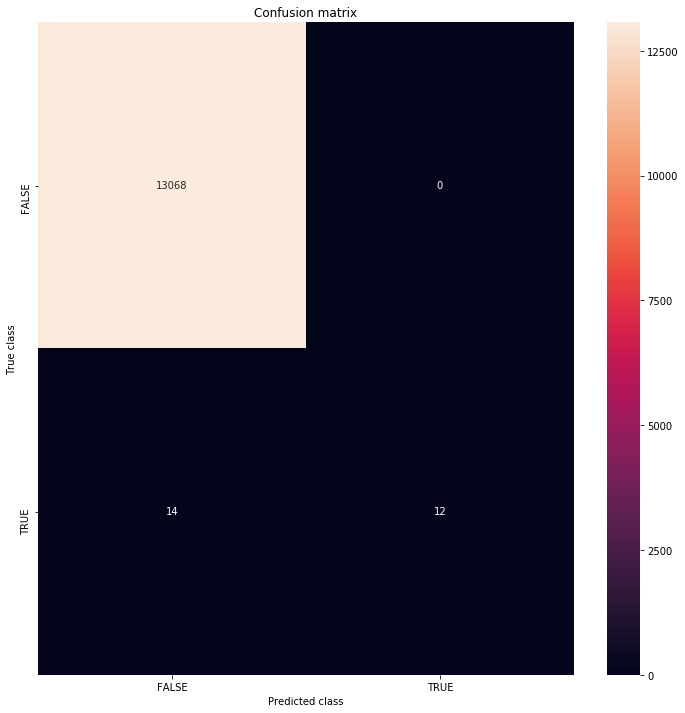

In [0]:
import seaborn as sns
LABELS = ['FALSE', 'TRUE']
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [0]:
csr = classification_report(error_df.true_class, y_pred)
print(csr)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     13068
        True       1.00      0.46      0.63        26

    accuracy                           1.00     13094
   macro avg       1.00      0.73      0.82     13094
weighted avg       1.00      1.00      1.00     13094

